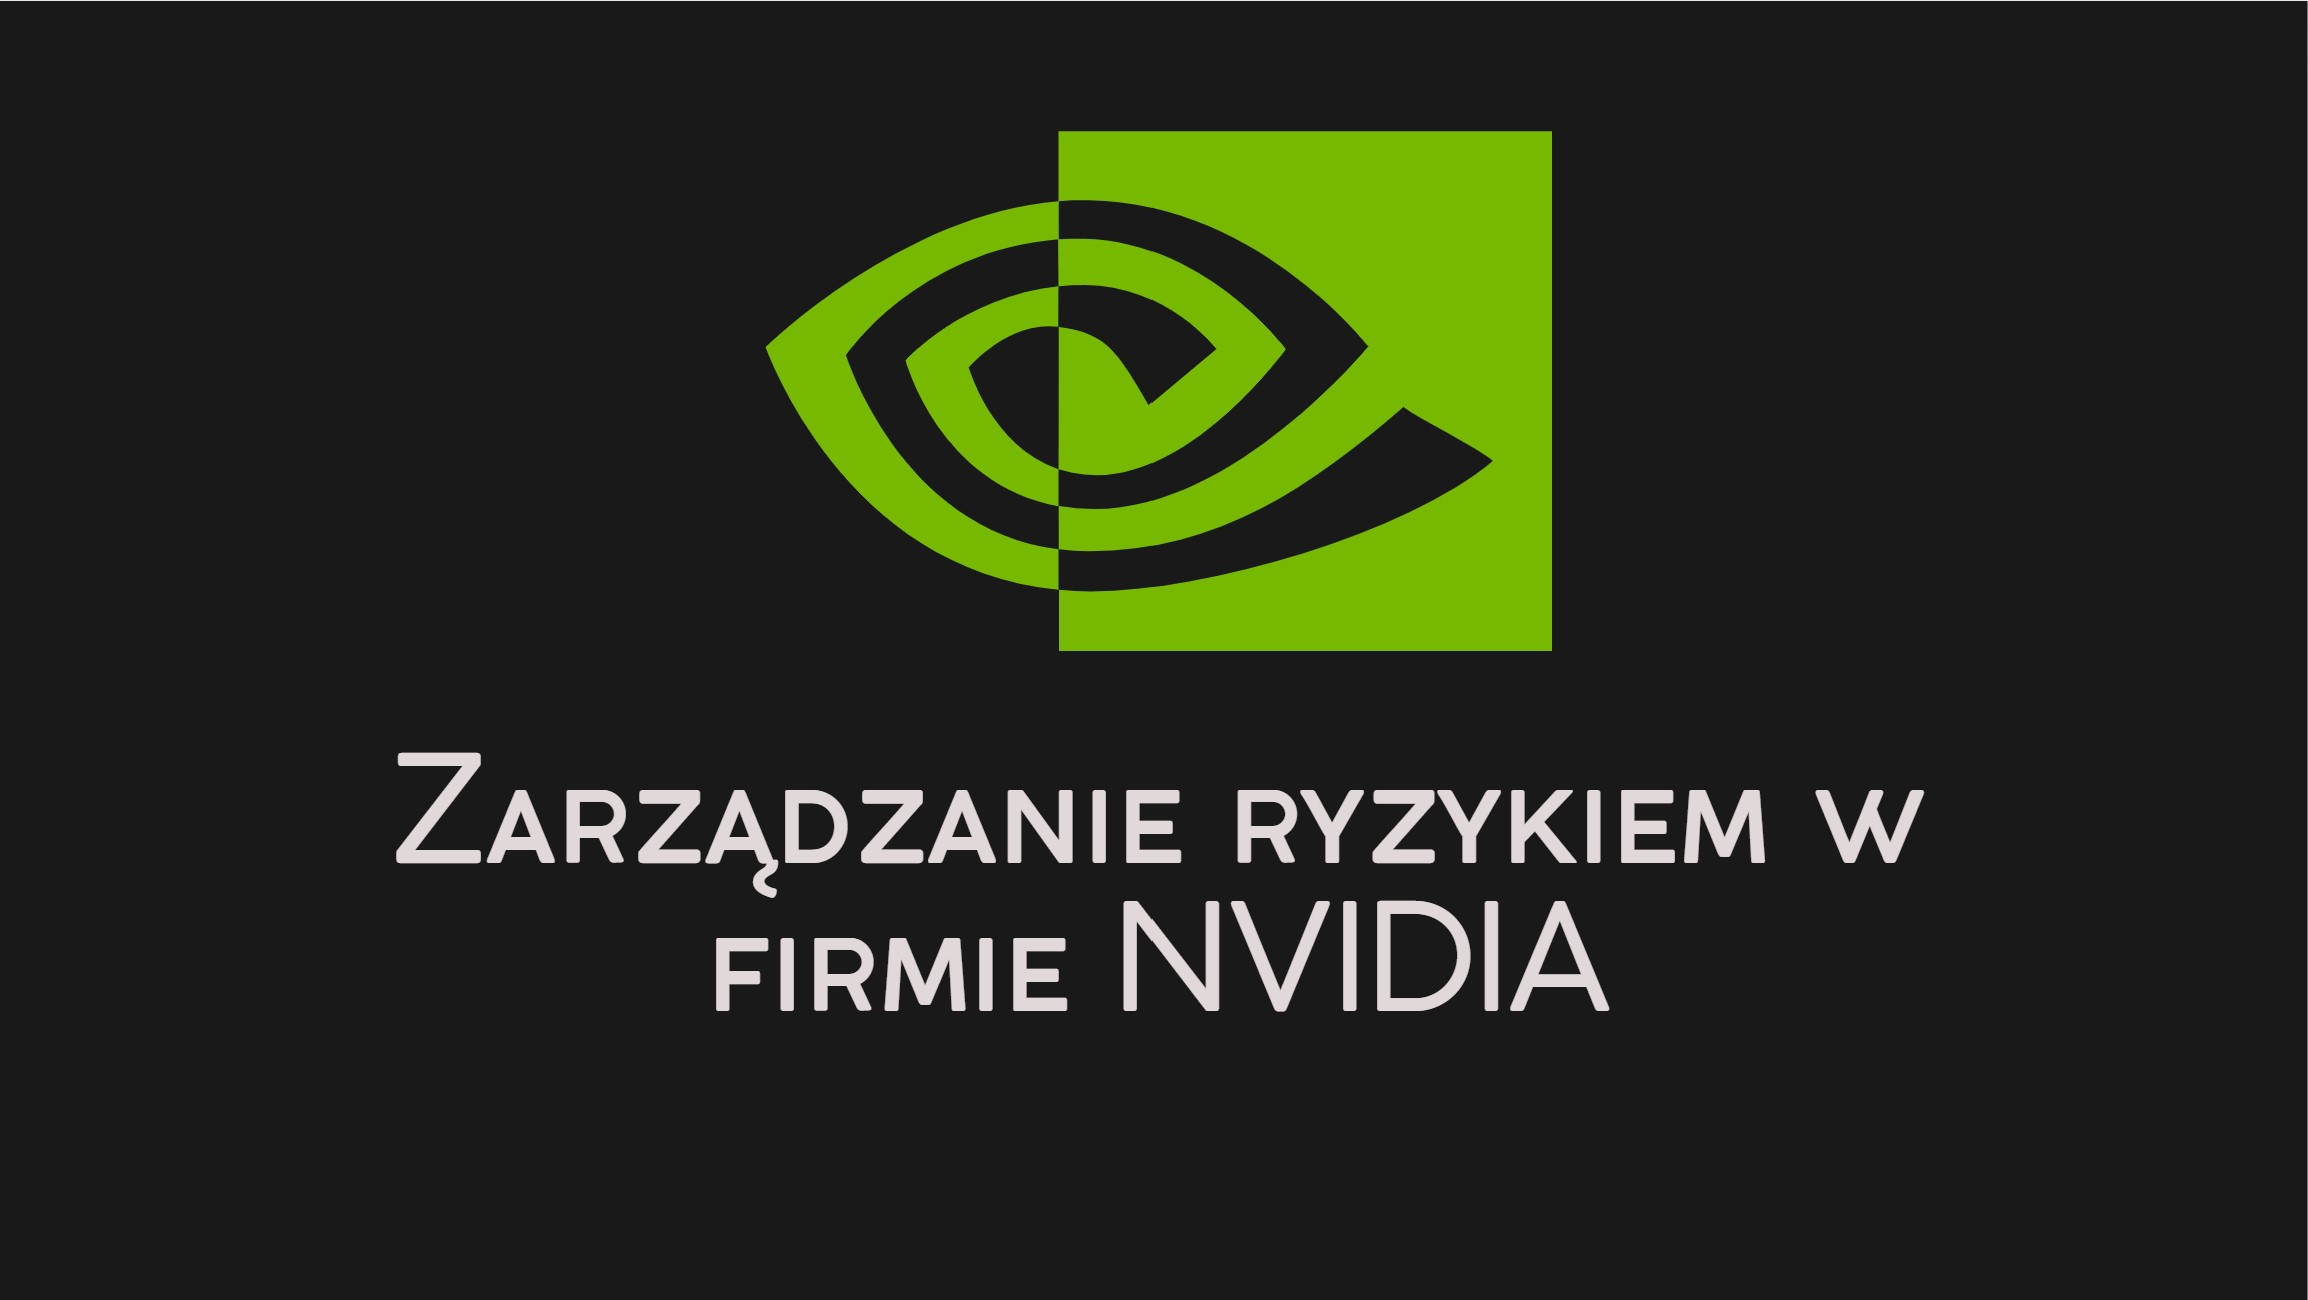

## Spis treści:
* [Miedź](#first-bullet)
* [Aluminium](#second-bullet)
* [Przypadek wielowymiarowy](#third-bullet)
* [Rozkład maksimów](#fourth-bullet)

In [375]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statistics import stdev
from scipy.stats import median_abs_deviation, skew, kurtosis, pearsonr, norm, logistic, laplace, kstest
from scipy.special import erf
import seaborn as sns; sns.set()

In [376]:
def equalize(df): #funkcja ta skaluje ceny miedzi do cen za tonę
    d = 2204.623
    col_names = [col for col in df.columns][1:]
    col_names.remove('Volume')
    for name in col_names:
        df[name] = df[name]*d
    return df

def draw_stock(df, clr, title): #funkcja rysuje wykres cen
    fig, ax = plt.subplots(figsize = (15, 4))
    plt.xticks(rotation = 45)
    xloc = plt.MaxNLocator(9)
    ax.xaxis.set_major_locator(xloc)
    dates = df['Date'].values[::-1]
    prices = df['Open'].values[::-1]
    plt.plot(dates, prices, color = clr)
    plt.ylabel('USD')
    plt.title(title, fontsize = 25)
    plt.show()
    
def draw_ret(df, clr, title): #funkcja rysuje wykres log stóp zwrotu
    fig, ax = plt.subplots(figsize = (15, 4))
    plt.xticks(rotation = 45)
    xloc = plt.MaxNLocator(9)
    ax.xaxis.set_major_locator(xloc)
    dates = df['Date'].values[::-1][:-1]
    prices1 = df['Open'].values[::-1][1:]
    prices2 = df['Open'].values[::-1][:-1]
    r = np.log(prices1/prices2)
    plt.plot(dates, r, color = clr, lw=1)
    plt.title(title, fontsize = 25)
    plt.show()

#Porównanie histogramu z wykresami funkcji gęstości
def norm_kde(x, title, best_fit = None, bin_no = 50):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    
    x = np.array(sorted(x))
    mi = np.mean(x)
    sigma = stdev(x)
    
    plt.hist(x, bins = bin_no, density = True, color = 'white', ec = 'black')
    y = norm.pdf(x, mi, sigma) #rozkład normalny
    plt.plot(x, y, color = 'blue', label = 'normal pdf')
    if best_fit == logistic:
        y2 = logistic.pdf(x, mi, math.sqrt(3)/math.pi*sigma) #rozkład logistyczny
        plt.plot(x, y2, color = 'red', label = 'logistic pdf')
    if best_fit == laplace:
        y2 = laplace.pdf(x, mi, 1/np.sqrt(2) * sigma)
        plt.plot(x, y2, color = 'red', label = 'laplace pdf')   
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.title(title, fontsize = 25)
    plt.show()

def comp_quantile(x, p1, p2, p3, dist = None): #p ma być z zakresu [0, 1]
    mi = np.mean(x)
    sigma = stdev(x)
    p = [p1, p2, p3]
    real = np.quantile(x, p)
    nrm = norm.ppf(p, mi, sigma)
    perc = [format(p, '.2%') for p in [p1, p2, p3]]
    if dist == logistic:
        lgstc = logistic.ppf(p, mi, math.sqrt(3)/math.pi*sigma)
        dct = {'p' : perc, 'hist' : real, 'normal' : nrm, 'logistic' : lgstc, 'error normal' : abs(real - nrm), 'error logistic' : abs(real - lgstc)}
    elif dist == laplace:
        lpl = laplace.ppf(p, mi, 1/np.sqrt(2) * sigma)
        dct = {'p' : perc, 'hist' : real, 'normal' : nrm, 'laplace' : lpl, 'error normal' : abs(real - nrm), 'error laplace' : abs(real - lpl)}
    else:
        dct = {'p' : perc, 'hist' : real}
    df = pd.DataFrame(dct)
    return df

#Porównanie dystrybuant teoretycznych z dystrybuantą empiryczną
def cdf(x, title, best_fit = None, port = False):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    
    x = np.array(sorted(x))
    mi = np.mean(x)
    sigma = stdev(x)
    
    sns.ecdfplot(data = x, color = 'blue', label = 'ECDF', linestyle = 'dashdot')
    if port == False:
        y = norm.cdf(x, mi, sigma)
        plt.plot(x, y, color = 'black', label = 'norm cdf', lw = .7)

    if best_fit == logistic:
        y2 = logistic.cdf(x, mi, math.sqrt(3)/math.pi*sigma) #rozkład logistyczny
        plt.plot(x, y2, color = 'red', label = 'logistic cdf', lw = .7)
    if best_fit == laplace:
        y2 = laplace.cdf(x, mi, 1/np.sqrt(2) * sigma)
        plt.plot(x, y2, color = 'red', label = 'laplace cdf', lw = .7)   

    plt.xlabel('x')
    plt.ylabel('F(x)')
    plt.legend()
    plt.title(title, fontsize = 25)
    plt.show()

def nearest(tbl, x):
    tbl = sorted(tbl)
    tbl = np.array(tbl)
    tbl1 = tbl - x
    tbl2 = tbl1[tbl1 < 0]
    idx = list(tbl1).index(max(tbl2))
    return idx

        
def comp_dist(x, dist = None, x0 = [-0.05, -0.03, -0.01, 0, 0.01, 0.03, 0.05]):
    x = sorted(x)
    mi = np.mean(x)
    sigma = stdev(x)
    
    ## REAL
    real = np.arange(len(x))/float(len(x))
    l = []
    for i in x0:
        idx = nearest(x, i)
        l_ = real[idx] + (real[idx + 1] - real[idx])/(x[idx + 1] - x[idx])*(i - x[idx])
        l.append(l_)
    nrm = norm.cdf(x0, mi, sigma)
    if dist == logistic:
        lgstc = logistic.cdf(x0, mi, math.sqrt(3)/math.pi*sigma)
        dct = {'x0' : x0, 'ecdf' : l, 'normal' : nrm, 'logistic' : lgstc, 'error normal' : abs(l - nrm), 'error logistic' : abs(l - lgstc)}
    elif dist == laplace:
        lpl = laplace.cdf(x0, mi, 1/np.sqrt(2) * sigma)
        dct = {'x0' : x0, 'ecdf' : l, 'normal' : nrm, 'laplace' : lpl, 'error normal' : abs(l - nrm), 'error laplace' : abs(l - lpl)}
    else:
        dct = {'x0' : x0, 'ecdf' : l}
    df = pd.DataFrame(dct)
    return df

__Zmienne ryzyka które będziemy rozważać:__
- Ceny miedzi
- Ceny aluminium

# Miedź <a class="anchor" id="first-bullet"></a>

In [377]:
copper_ = pd.read_csv('data/copper.csv', sep = ',', encoding = 'latin-1')
copper = equalize(copper_) #ceny miedzi przeskalowane do ton

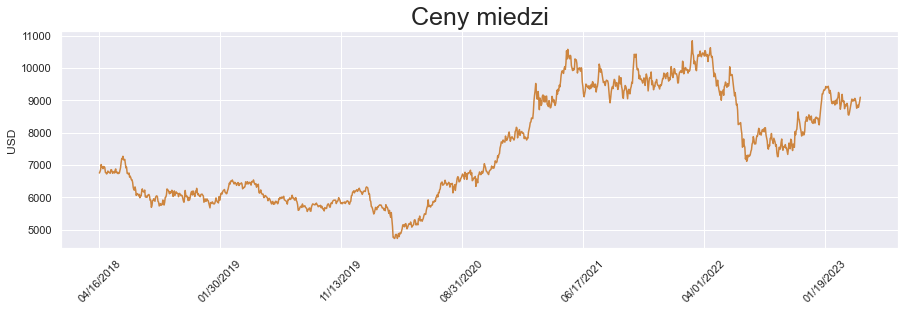

In [378]:
draw_stock(copper, 'peru', 'Ceny miedzi')

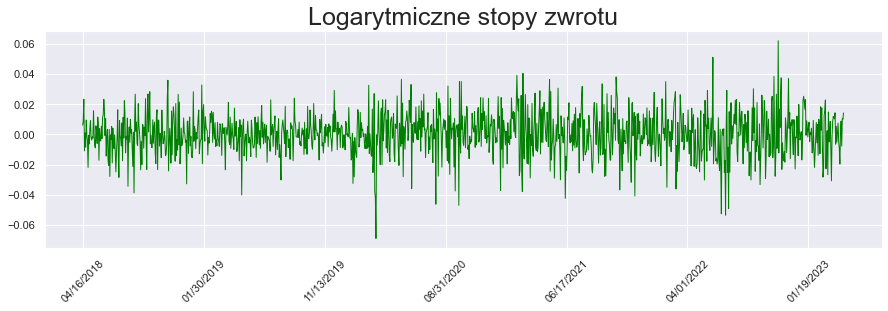

In [379]:
s = np.array(copper['Open'].values)
r = np.log(s[1:]/s[:-1])
draw_ret(copper, 'green', 'Logarytmiczne stopy zwrotu')

In [380]:
print('Średnia: ' + str(np.mean(r)))
print('Wariancja: ' + str(np.var(r)))
print('Odchylenie standardowe: ' + str(len(r)/(len(r)+1) * stdev(r)))
print('Odchylenie przeciętne: ' + str(median_abs_deviation(r)))
print('Odchylenie ćwiartkowe: ' + str(0.5*(np.quantile(r, .75) - np.quantile(r, .25))))
print('Skośność: ' + str(skew(r)))
print('Kurtoza: ' + str(kurtosis(r)))
print('Pierwszy kwartyl: ' + str(np.quantile(r, .25)))
print('Mediana: ' + str(np.quantile(r, .5)))
print('Trzeci kwartyl: ' + str(np.quantile(r, .75)))

Średnia: -0.0002367193970863344
Wariancja: 0.00020321096766212561
Odchylenie standardowe: 0.014249554983119849
Odchylenie przeciętne: 0.008379502169224238
Odchylenie ćwiartkowe: 0.008443862670245503
Skośność: 0.17440041345123358
Kurtoza: 1.184339957347377
Pierwszy kwartyl: -0.00903230848294452
Mediana: -0.0001925113106339907
Trzeci kwartyl: 0.007855416857546486


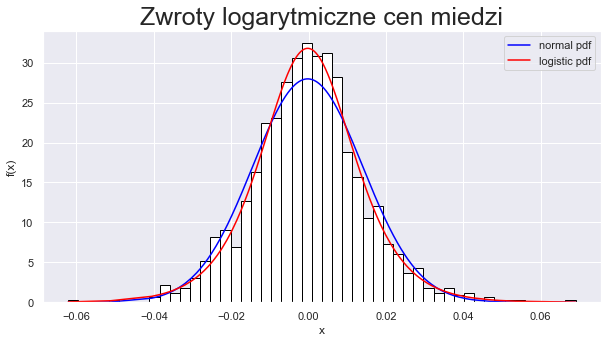

In [381]:
norm_kde(r, 'Zwroty logarytmiczne cen miedzi', logistic)

In [382]:
kstest(r, 'logistic', [np.mean(r), np.sqrt(3)/np.pi * np.std(r)])

KstestResult(statistic=0.017453199466375247, pvalue=0.8311462591278722)

In [383]:
comp_quantile(r, .95, .975, .99, logistic)

,p,hist,normal,logistic,error normal,error logistic
0,95.00%,0.023471,0.023220,0.022914,0.000251,0.000557
1,97.50%,0.028709,0.027714,0.028568,0.000995,0.000141
2,99.00%,0.037609,0.032939,0.035892,0.004670,0.001717


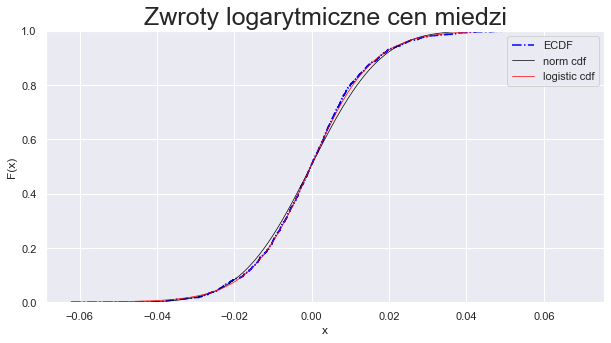

In [384]:
cdf(r, 'Zwroty logarytmiczne cen miedzi', logistic)

In [385]:
comp_dist(r, dist = logistic)

,x0,ecdf,normal,logistic,error normal,error logistic
0,-0.05,0.000878,0.000242,0.001780,0.000636,0.000902
1,-0.03,0.016897,0.018441,0.022194,0.001544,0.005297
2,-0.01,0.226396,0.246792,0.224129,0.020395,0.002267
3,0.00,0.505957,0.506622,0.507526,0.000665,0.001569
4,0.01,0.800190,0.763565,0.786168,0.036624,0.014022
5,0.03,0.976878,0.983008,0.979076,0.006130,0.002198
6,0.05,0.997004,0.999786,0.998324,0.002783,0.001320


# Aluminium <a class="anchor" id="second-bullet"></a>

In [386]:
aluminium = pd.read_csv('data/aluminium.csv', sep = ',', encoding = 'latin-1')   # ceny aluminium (przed ucięciem)

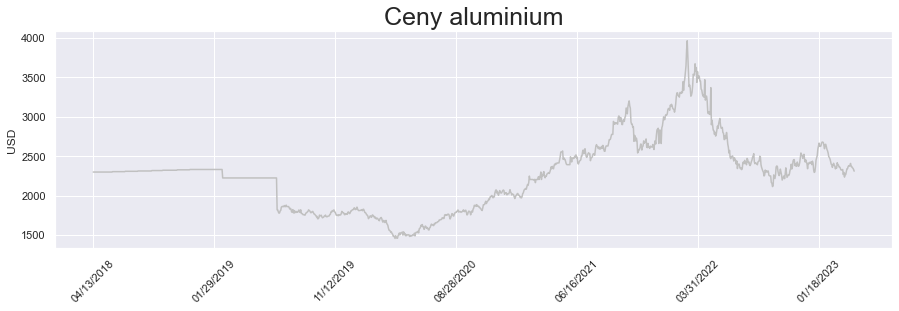

In [387]:
draw_stock(aluminium, 'silver', 'Ceny aluminium')

In [388]:
idx = aluminium.index[aluminium['Date'] == '07/01/2019'].tolist()[0]
idx # idx = 952
aluminium2 = aluminium.drop(aluminium.index[idx:1259]) #ceny aluminium (po ucięciu)

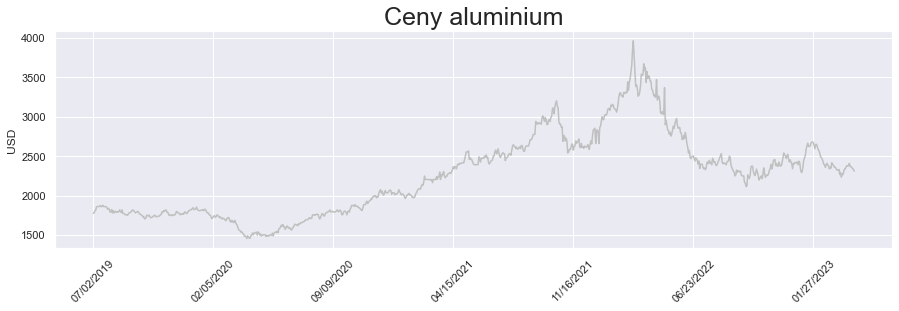

In [389]:
draw_stock(aluminium2, 'silver', 'Ceny aluminium')

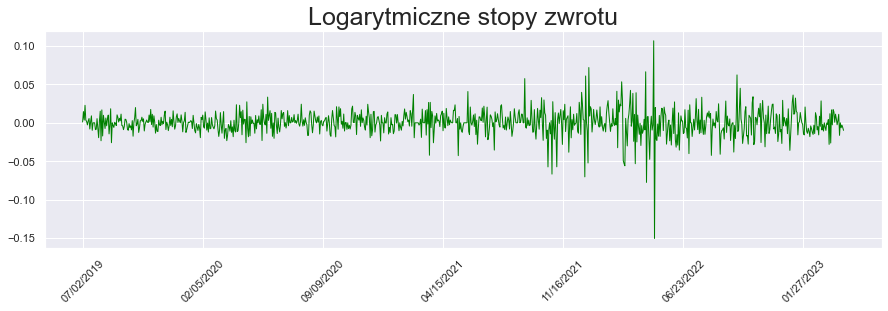

In [390]:
s_ = np.array(aluminium2['Open'].values)
r2 =  np.log(s_[1:]/s_[:-1])
draw_ret(aluminium2, 'green', 'Logarytmiczne stopy zwrotu')

In [391]:
print('Średnia: ' + str(np.mean(r2)))
print('Wariancja: ' + str(np.var(r2)))
print('Odchylenie standardowe: ' + str(len(r2)/(len(r2)+1) * stdev(r2)))
print('Odchylenie przeciętne: ' + str(median_abs_deviation(r2)))
print('Odchylenie ćwiartkowe: ' + str(0.5*(np.quantile(r2, .75) - np.quantile(r2, .25))))
print('Skośność: ' + str(skew(r2)))
print('Kurtoza: ' + str(kurtosis(r2)))
print('Pierwszy kwartyl: ' + str(np.quantile(r2, .25)))
print('Mediana: ' + str(np.quantile(r2, .5)))
print('Trzeci kwartyl: ' + str(np.quantile(r2, .75)))

Średnia: -0.0002754048568726295
Wariancja: 0.00027281978602528673
Odchylenie standardowe: 0.016508589036051853
Odchylenie przeciętne: 0.008324835433568057
Odchylenie ćwiartkowe: 0.008352027059498843
Skośność: 0.688756968721271
Kurtoza: 11.012603187743872
Pierwszy kwartyl: -0.008764626707863613
Mediana: 0.0
Trzeci kwartyl: 0.007939427411134074


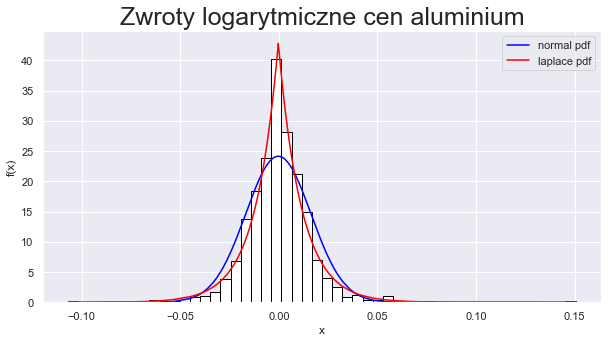

In [392]:
norm_kde(r2, 'Zwroty logarytmiczne cen aluminium', laplace)

In [393]:
kstest(r2, 'laplace', [np.mean(r), 1/np.sqrt(2) * np.std(r)])

KstestResult(statistic=0.03997019263806101, pvalue=0.09323378909182489)

In [394]:
comp_quantile(r2, .95, .975, .99, laplace)

,p,hist,normal,laplace,error normal,error laplace
0,95.00%,0.023344,0.026907,0.026632,0.003564,0.003288
1,97.50%,0.031319,0.032115,0.034732,0.000796,0.003412
2,99.00%,0.050773,0.038170,0.045439,0.012603,0.005334


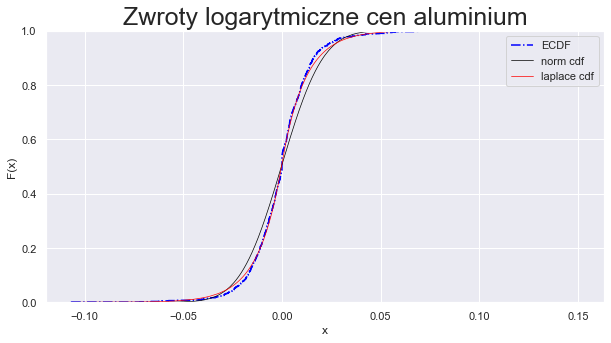

In [395]:
cdf(r2, 'Zwroty logarytmiczne cen aluminium', laplace)

In [396]:
comp_dist(r2, dist = laplace)

,x0,ecdf,normal,laplace,error normal,error laplace
0,-0.05,0.006729,0.001311,0.007095,0.005418,0.000366
1,-0.03,0.022980,0.036036,0.039288,0.013056,0.016308
2,-0.01,0.220291,0.278117,0.217549,0.057826,0.002743
3,0.00,0.487907,0.506648,0.511646,0.018741,0.023739
4,0.01,0.800891,0.732955,0.792468,0.067936,0.008423
5,0.03,0.972576,0.966524,0.962521,0.006052,0.010055
6,0.05,0.988682,0.998826,0.993232,0.010143,0.004549


# PRZYPADEK WIELOWYMIAROWY <a class="anchor" id="third-bullet"></a>

In [397]:
idx = 952 #liczone przy aluminium
stock1 = copper['Open'].values[:idx][::-1]
stock2 = aluminium['Open'].values[:idx][::-1]
s = np.array(stock1[1:])
s2 = np.array(stock1[:-1])
r1 = np.log(s/s2)
s_ = np.array(stock2[1:])
s2_ = np.array(stock2[:-1])
r2 =  np.log(s_/s2_)

#funkcja tworzy portfel z dwóch zmiennych ryzyka - w1 i w2 to wagi portfela
def portfolio(x1, x2, w1, w2):
    try:
        x = w1*x1 + w2*x2
    except ValueError:
        print('Rozmiary próbek muszą być równe!')
    return x

# zwroty logarytmiczne portfela (jakie wagi bierzemy ???)
w1 = 0.55
w2 = 0.45
port = portfolio(r1, r2, w1, w2)

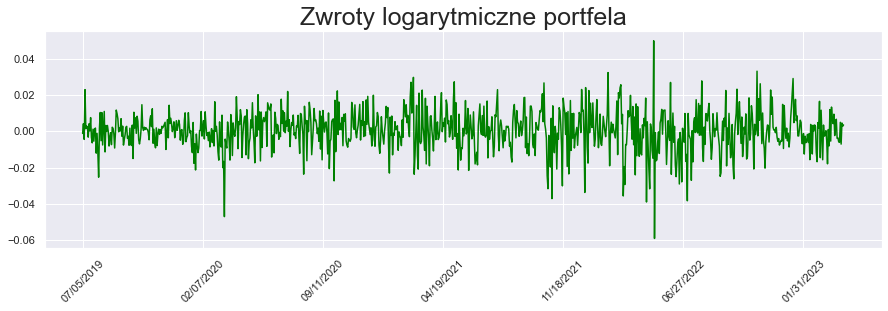

In [398]:
fig, ax = plt.subplots(figsize = (15, 4))
plt.xticks(rotation = 45)
xloc = plt.MaxNLocator(9)
ax.xaxis.set_major_locator(xloc)
dates = copper['Date'].values[1:idx][::-1]
plt.plot(dates, port, color = 'green')
plt.title('Zwroty logarytmiczne portfela', fontsize = 25)
plt.show()

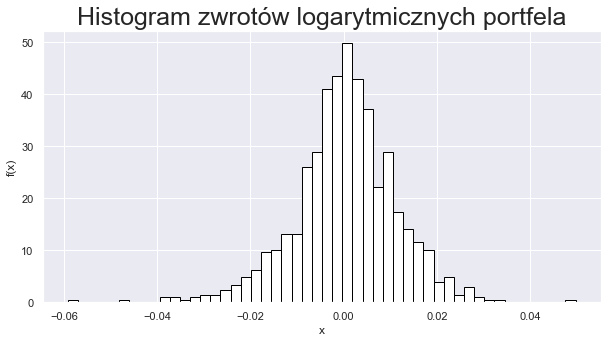

In [399]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(port, bins = 50, density = True, color = 'white', ec = 'black')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Histogram zwrotów logarytmicznych portfela', fontsize = 25)
plt.show()

In [400]:
comp_quantile(port, .95, .975, .99)

,p,hist
0,95.00%,0.017448
1,97.50%,0.021510
2,99.00%,0.026332


Text(0, 0.5, '')

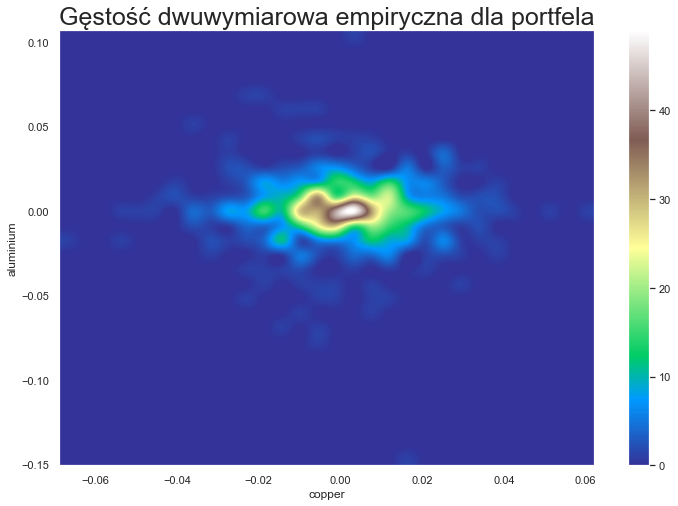

In [401]:
heatmap, xedges, yedges = np.histogram2d(r1, r2, bins = 30)

fig = plt.figure(figsize = (12, 8))
plt.imshow(heatmap.T, interpolation="spline36", 
               cmap = 'terrain',
              extent = [min(xedges), max(xedges),
                       min(yedges), max(yedges)],
          aspect = 'auto',
          origin = 'lower')
plt.grid(visible = False)
plt.xlabel('copper')
plt.ylabel('aluminium')
plt.title('Gęstość dwuwymiarowa empiryczna dla portfela', fontsize = 25)
cbar = plt.colorbar()
cbar.ax.set_ylabel('')

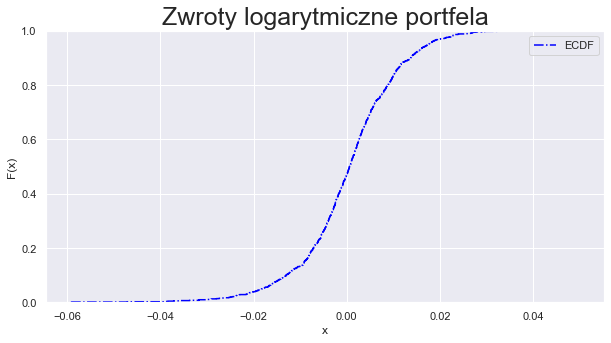

In [402]:
cdf(port, 'Zwroty logarytmiczne portfela', True, True)

In [417]:
comp_dist(port, logistic)

IndexError: index 951 is out of bounds for axis 0 with size 951

In [416]:
len(port)

951

In [404]:
def cdf_2d(x, y):
    try:
        heatmap = np.zeros((len(x), len(y)))
        x_ = np.linspace(min(x), max(x), len(x))
        y_ = np.linspace(min(y), max(y), len(y))
        for i in range(len(x)):
            for j in range(len(y)):
                heatmap[i][j] = len(x[x < x_[i]])/len(x)*len(y[y < y_[j]])/len(y)
        fig = plt.figure(figsize = (12, 8))
        plt.imshow(heatmap.T, interpolation="spline36", 
                       cmap = 'Greens',
                      extent = [min(x), max(x),
                               min(y), max(y)],
                  aspect = 'auto',
                  origin = 'lower')
        plt.grid(visible = False)
        plt.xlabel('copper')
        plt.ylabel('aluminium')
        cbar = plt.colorbar()
        cbar.ax.set_ylabel('')
        plt.title('Dystrybuanta dwuwymiarowa empiryczna dla portfela', fontsize = 25)
        plt.show()
    except ValueError:
        print('Różne rozmiary prób!')

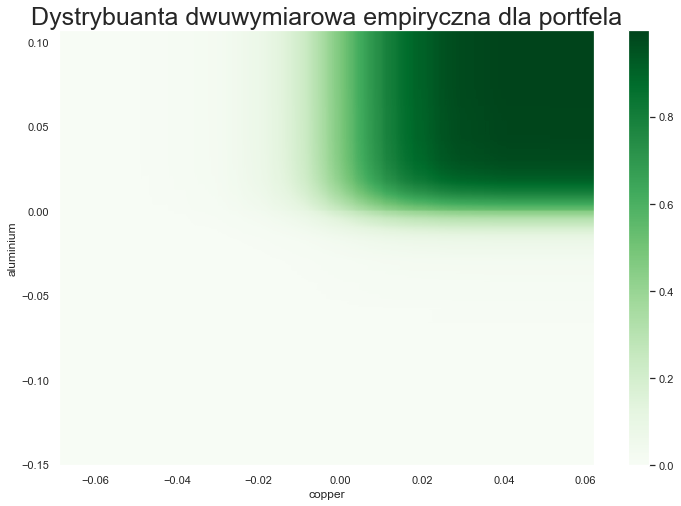

In [405]:
cdf_2d(r1, r2)

In [406]:
np.cov(np.array([list(r1), list(r2)]), bias = True)

array([[ 2.22386882e-04, -6.65034117e-06],
       [-6.65034117e-06,  2.72819786e-04]])

In [407]:
np.var(r1)

0.00022238688239529324

# ROZKŁAD MAKSIMÓW <a class="anchor" id="fourth-bullet"></a>

In [408]:
copper_10y = pd.read_csv('data/copper10yrs.csv')

Y = np.array(copper_10y.Open.values[::-1])
X = np.log(Y[1:] / Y[:-1])
X = X[X > 0]

n = 126
ksi = 0.07568019006684479
mu = 0.02144249900604158
sigma = 0.008213164153487319


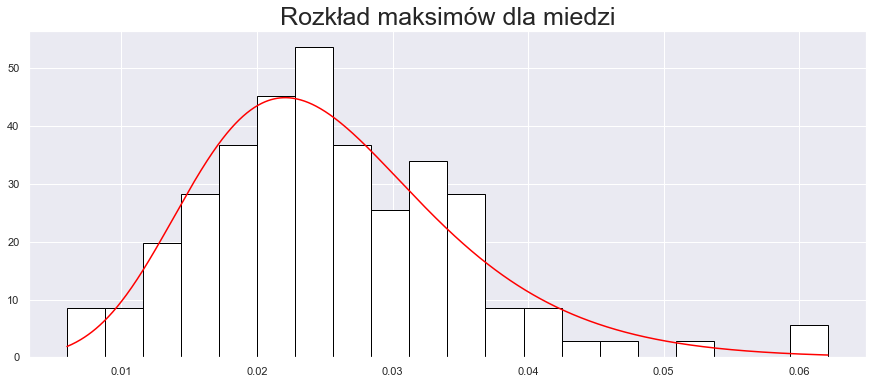

In [409]:
L = []
step = 10
i = step
while i < len(X) + 1:
    L.append(max(X[i-step:i]))
    i += step
print('n =', len(L))

ksi, mu, sigma = sp.genextreme.fit(L)
print('ksi =', ksi)
print('mu =', mu)
print('sigma =', sigma)

plt.figure(figsize=(15, 6))
plt.hist(L, bins=20, density=True, color = 'white', ec = 'black')
xs = np.linspace(min(L), max(L), 1000)
plt.plot(xs, sp.genextreme.pdf(xs, ksi, mu, sigma), c='red')
plt.title('Rozkład maksimów dla miedzi', fontsize = 25)
plt.show()

In [410]:
Y = np.array(aluminium2.Open.values[::-1])
X = np.log(Y[1:] / Y[:-1])
X = X[X > 0]

n = 46
ksi = -0.2566022727570442
mu = 0.021359287947934964
sigma = 0.008716402453550754


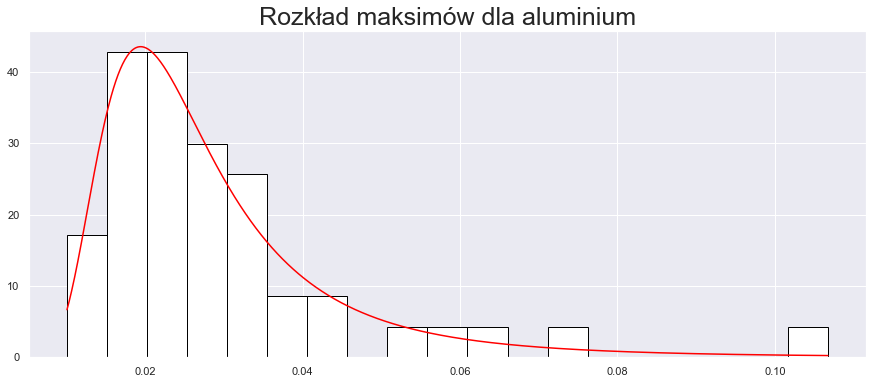

In [411]:
L = []
step = 10
i = step
while i < len(X) + 1:
    L.append(max(X[i-step:i]))
    i += step
print('n =', len(L))

ksi, mu, sigma = sp.genextreme.fit(L)
print('ksi =', ksi)
print('mu =', mu)
print('sigma =', sigma)

plt.figure(figsize=(15, 6))
plt.hist(L, bins=19, density=True, color = 'white', ec = 'black')
xs = np.linspace(min(L), max(L), 1000)
plt.plot(xs, sp.genextreme.pdf(xs, ksi, mu, sigma), c='red')
plt.title('Rozkład maksimów dla aluminium', fontsize = 25)
plt.show()

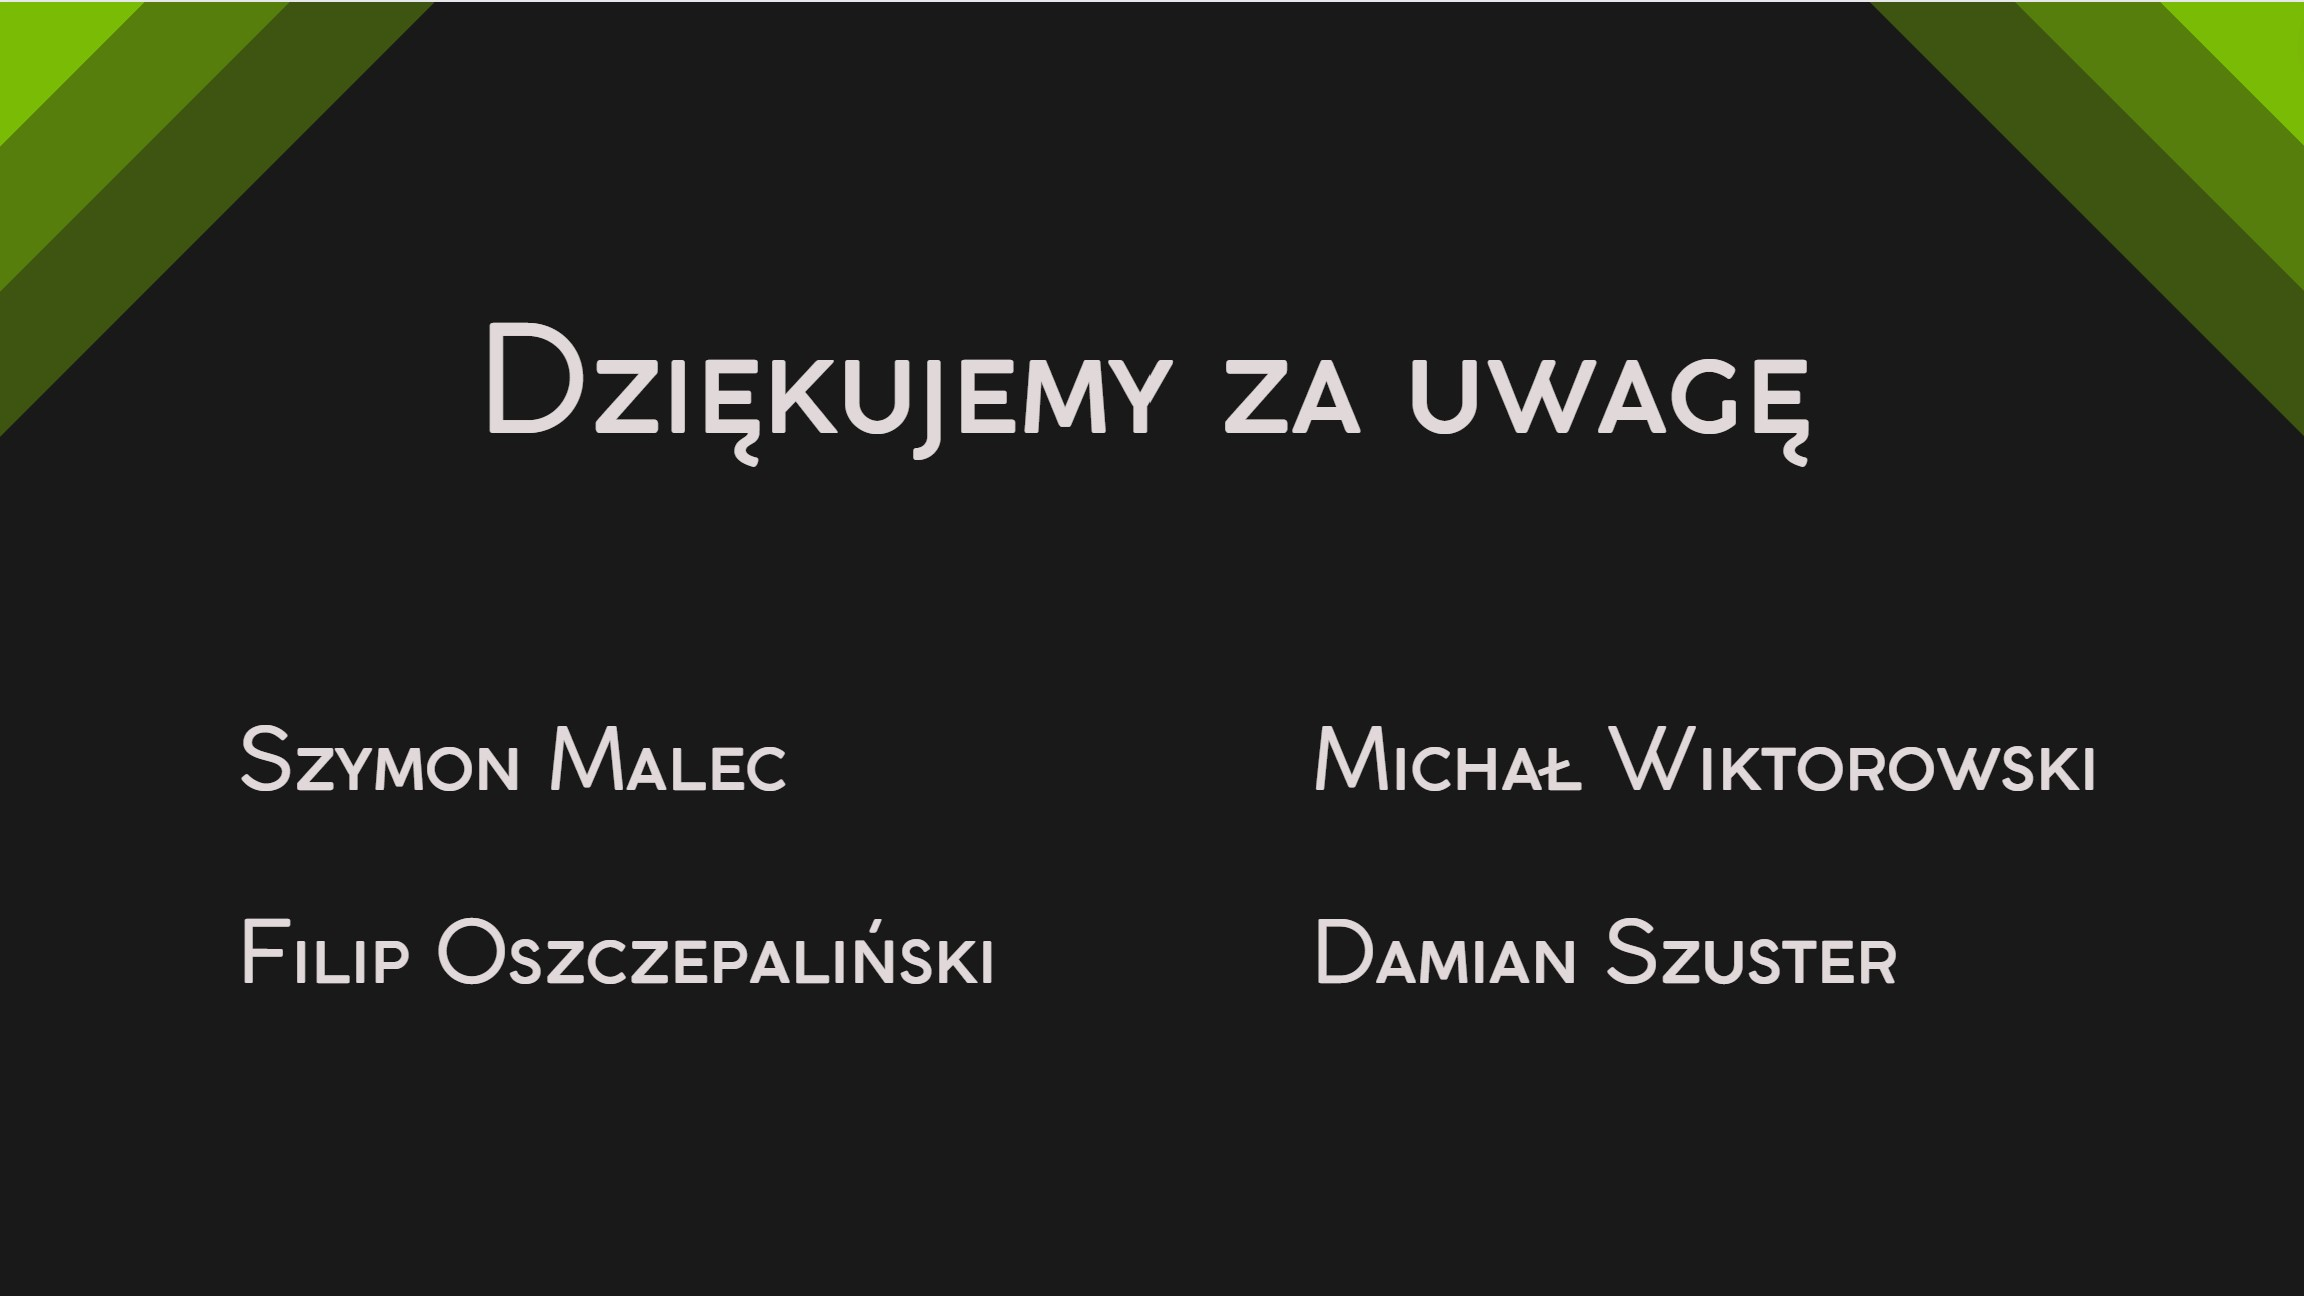